# ScRNA-Seq of human PBMCs

<br>Data: https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_10k_v3

In [1]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [2]:
file_base = '../../../../../data/raw/immune_cells/pbmcs_human/10X_pbmcs_10k/'
adata = sc.read_10x_mtx(path=file_base, var_names='gene_symbols', make_unique=True, cache=True, gex_only=True )
adata.X = adata.X.toarray()
adata.var_names_make_unique()

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [3]:
print(adata.X.shape)
print(adata)

(11769, 33538)
AnnData object with n_obs × n_vars = 11769 × 33538
    var: 'gene_ids', 'feature_types'


In [4]:
adata.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


## Preprocessing

In [5]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    n_counts  log_n_counts  n_genes  log_n_genes  \
AAACCCAAGCGCCCAT-1    2204.0      7.698483     1087     6.992096   
AAACCCAAGGTTCCGC-1   20090.0      9.908028     4200     8.343078   
AAACCCACAGAGTTGG-1    5884.0      8.680162     1836     7.515889   
AAACCCACAGGTATGG-1    5530.0      8.618124     2216     7.703910   
AAACCCACATAGTCAC-1    5106.0      8.538367     1615     7.387709   
...                      ...           ...      ...          ...   
TTTGTTGGTGTCATGT-1    3937.0      8.278428     1331     7.194437   
TTTGTTGGTTTGAACC-1    4245.0      8.353733     1401     7.245655   
TTTGTTGTCCAAGCCG-1    5602.0      8.631058     1668     7.419980   
TTTGTTGTCTTACTGT-1    6757.0      8.818482     1745     7.465083   
TTTGTTGTCTTCTAAC-1    1671.0      7.421776      698     6.549651   

                    pct_counts_in_top_20_genes   mt_frac  ribo_frac  hem_frac  
AAACCCAAGCGCCCAT-1                    0.245009  0.023593   0.177858       0.0  
AAACCCAAGGTTCCGC-1     

In [6]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,5,5])

Number of cells before QC filtering: 11769
Number of cells removed by log_n_genes filtering: 536
Number of cells removed by log_n_counts filtering: 524
Number of cells removed by pct_counts_in_top_20_genes filtering: 794
Number of cells removed by mt_frac filtering: 853
Number of cells post QC filtering: 10702
Number of genes before filtering: 33538
Number of genes after filtering so theres min 20 unique cells per gene: 15817


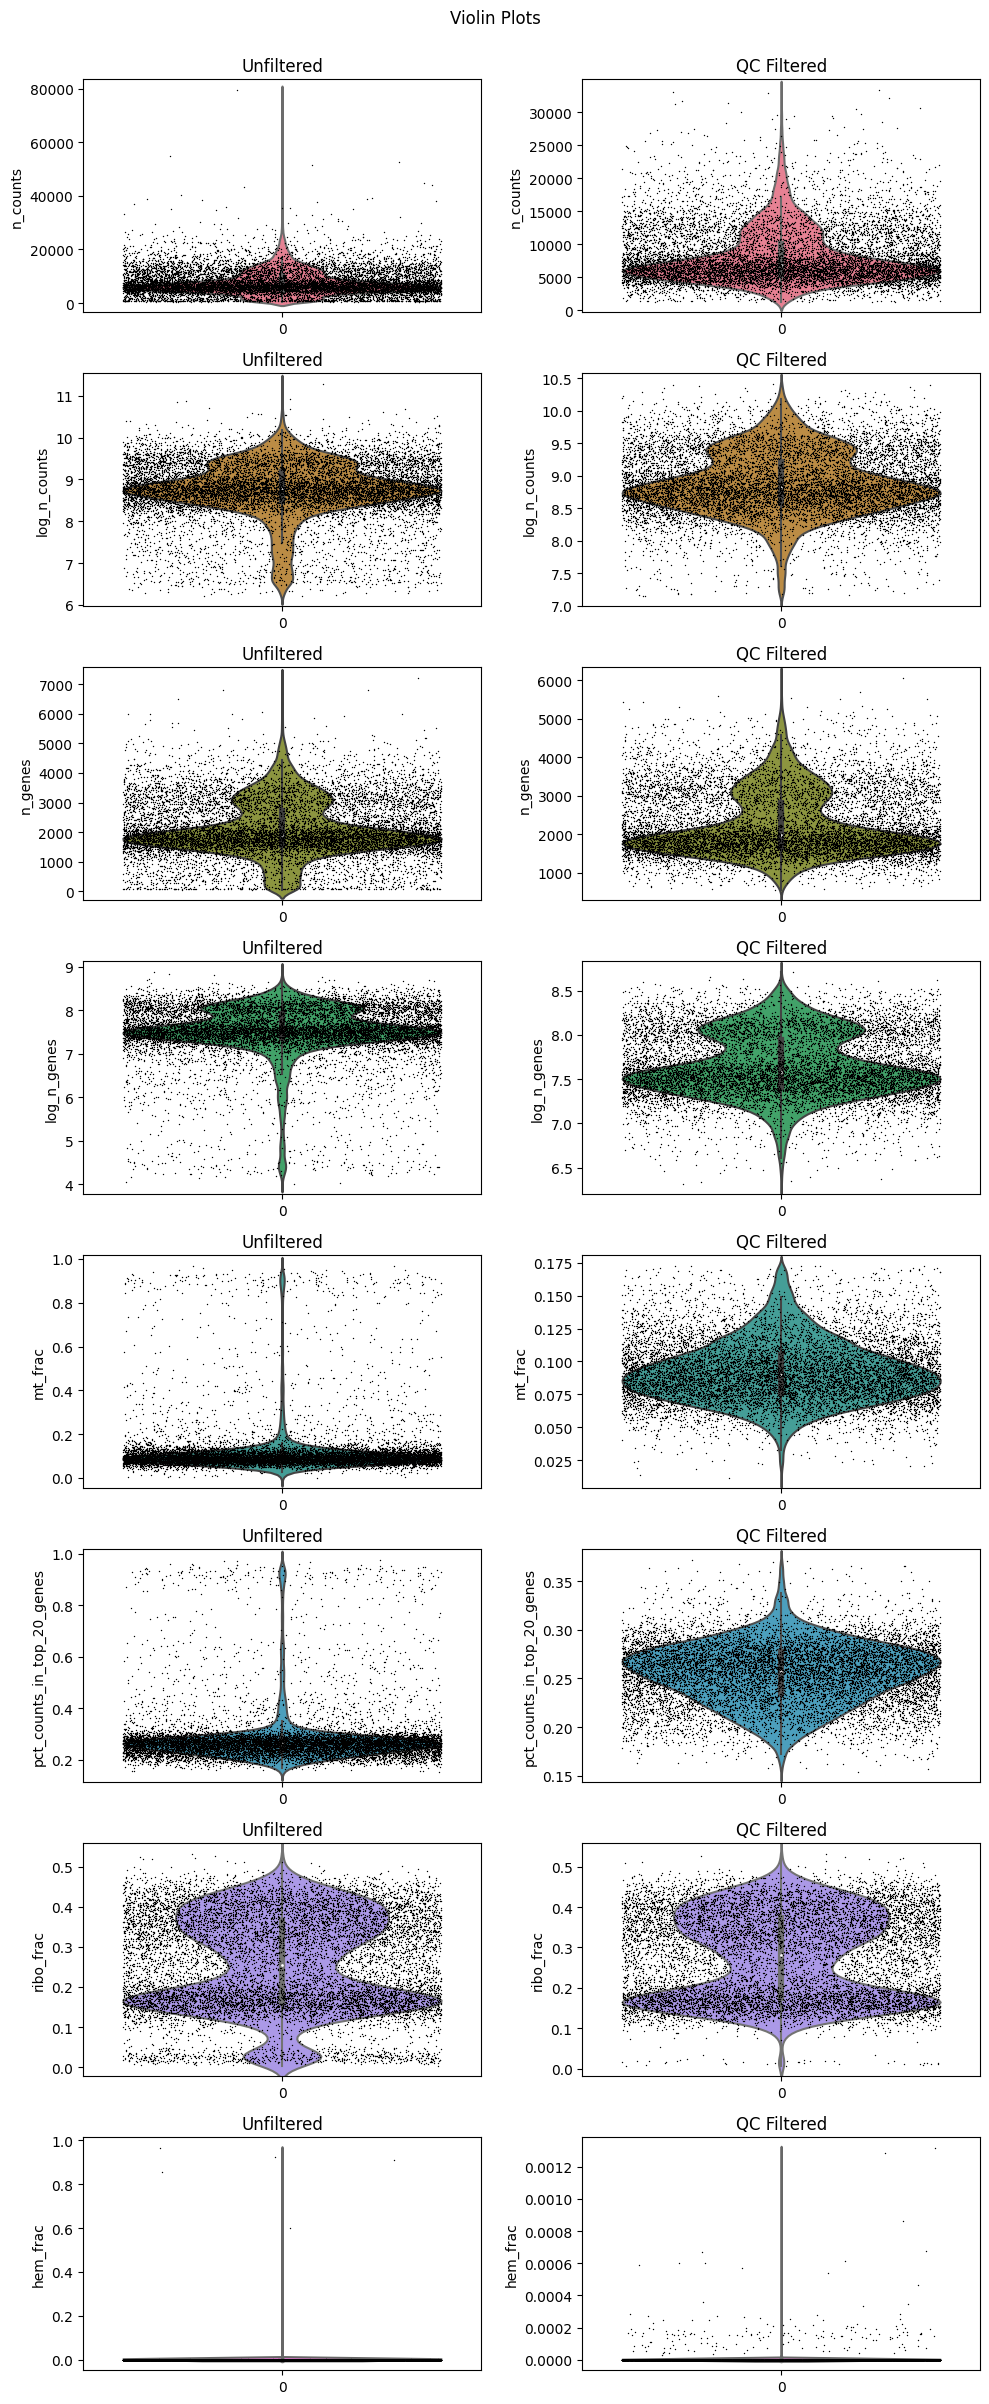

In [7]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes','ribo_frac','hem_frac'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

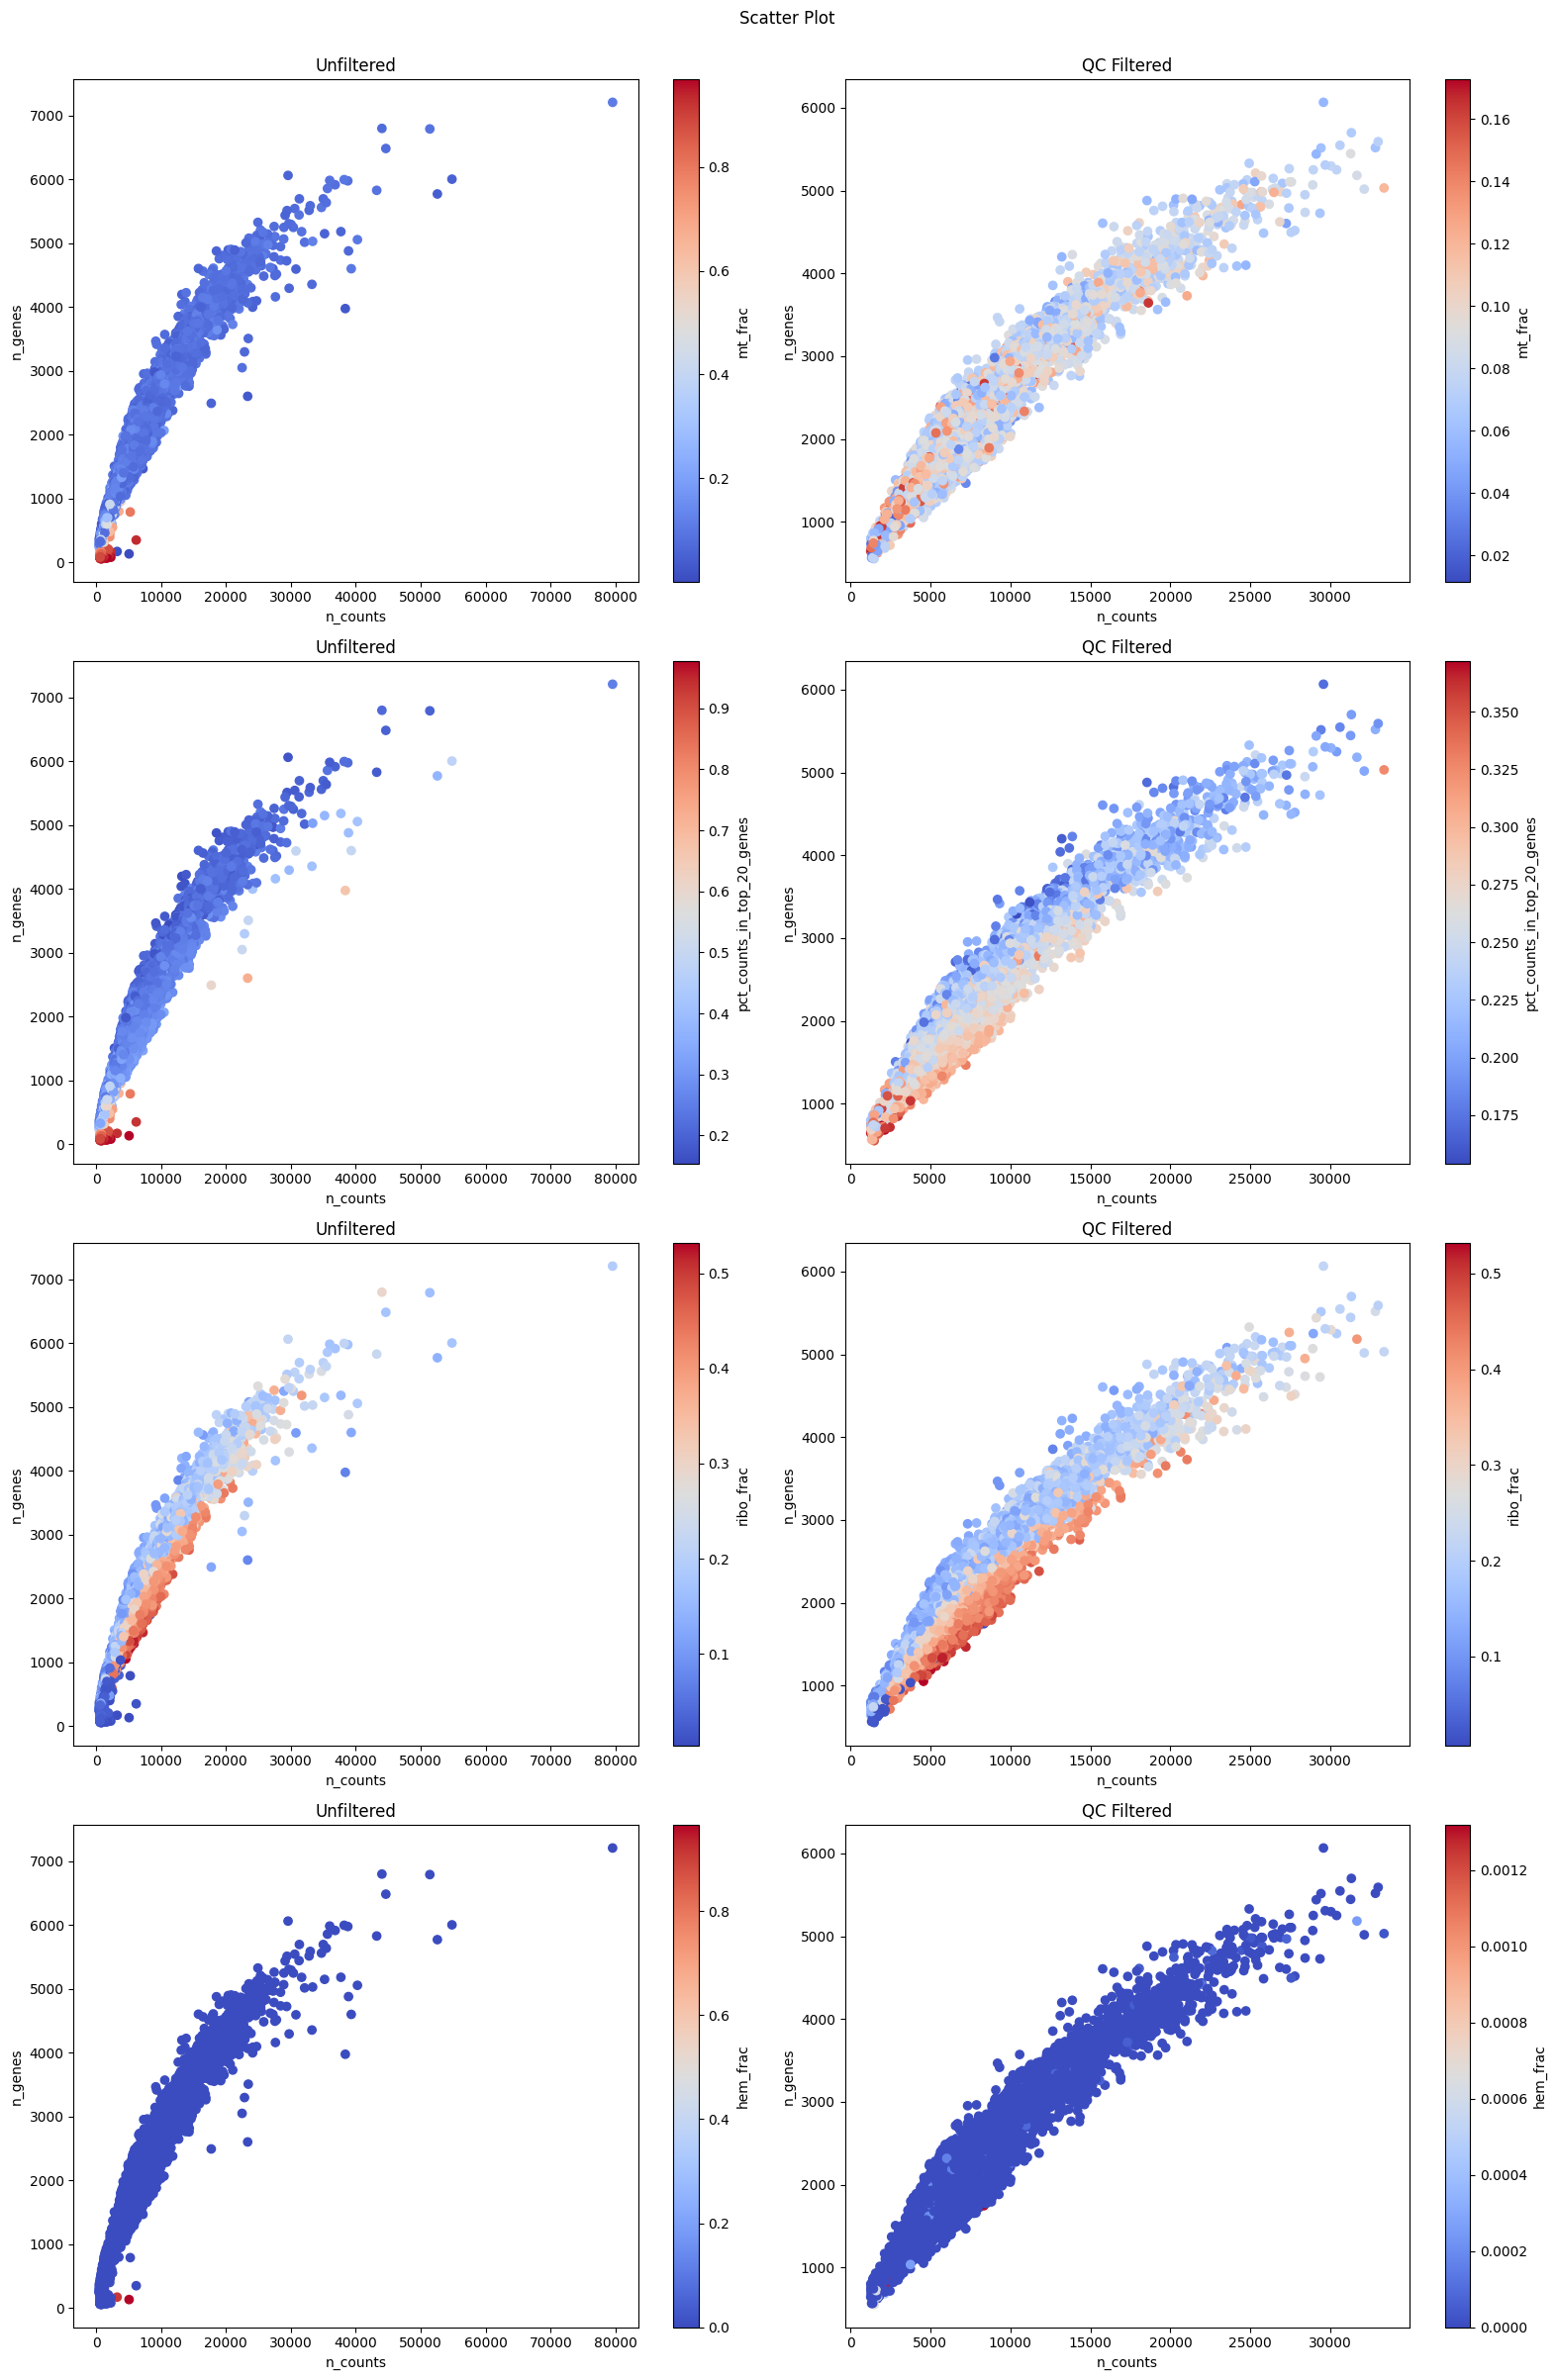

In [8]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [9]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [10]:
norm_qc_adata

AnnData object with n_obs × n_vars = 10702 × 15817
    obs: 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'ribo_frac', 'hem_frac', 'outlier', 'size_factors'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'pp_counts', 'log1p_counts'

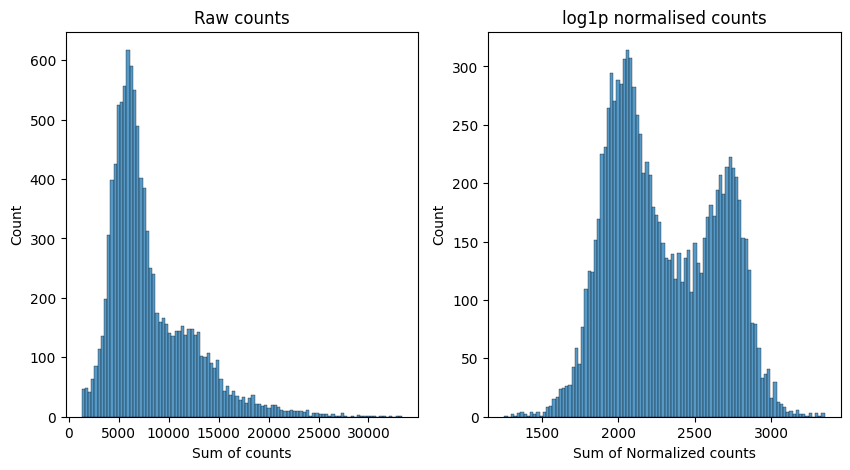

In [11]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [12]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("PBMCs_6.csv")
norm_qc_adata.write("PBMCs_6_adata.h5ad")